In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
from data_utils import MIT_split_dataset, CustomTransform
from model_luis import Model
from train_utils import validate
# !pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
config = {
    'IMG_WIDTH': 256,
    'IMG_HEIGHT': 256,
    'TRAINING_DATASET_DIR': 'data/MIT_small_train_1/train',
    'VALIDATION_DATASET_DIR': 'data/MIT_small_train_1/test',
    'TEST_DATASET_DIR': 'data/MIT_split/test',
    'learning_rate': 0.001,
    'batch_size': 32,
    'decay': 0.001,
    'n_epochs': 50
}

transform_test = CustomTransform(config, mode='test')
dataset_test = MIT_split_dataset(config['TEST_DATASET_DIR'], transform=transform_test)
dataloader_test = DataLoader(dataset_test, batch_size=config['batch_size'], shuffle=False)

In [3]:
state_dict = torch.load("model_files/best_model.pth", map_location=device)
model = Model(num_classes=8).to(device)
model.load_state_dict(state_dict)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

Number of parameters: 307464


In [4]:
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = validate(model, dataloader_test, criterion, device)
print(f"Test accuracy: {test_acc:.3f} | Test Loss: {test_loss:.4f}")

100%|██████████| 26/26 [00:54<00:00,  2.08s/it]

Test accuracy: 74.597 | Test Loss: 0.0306


In [5]:
# Read image
img_path = "data/MIT_small_train_1/test/highway/art803.jpg"
img = Image.open(img_path)
img_tensor = transform_test(read_image(img_path)).float()[None, :]

# Predicted probabilities
pred_logits = model(img_tensor)
print(*[f"\n{c}: {p:.3f}" for c, p in zip(dataset_test.classes, F.softmax(pred_logits, dim=-1)[0])])

# We want to see the attention map for the predicted class
pred_img_label = torch.argmax(pred_logits)


Opencountry: 0.038 
coast: 0.015 
forest: 0.718 
highway: 0.013 
inside_city: 0.005 
mountain: 0.131 
street: 0.079 
tallbuilding: 0.000


In [6]:
# Compute attention map for each target layer
visualizations = []
for target_layer in [model.squeeze_block1.expand3x3, model.squeeze_block2.expand3x3, model.final_conv]:
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(pred_img_label)])
    grayscale_cam = grayscale_cam[0, :]
    visualizations.append(
        show_cam_on_image((np.array(img)/255), grayscale_cam, use_rgb=True))    


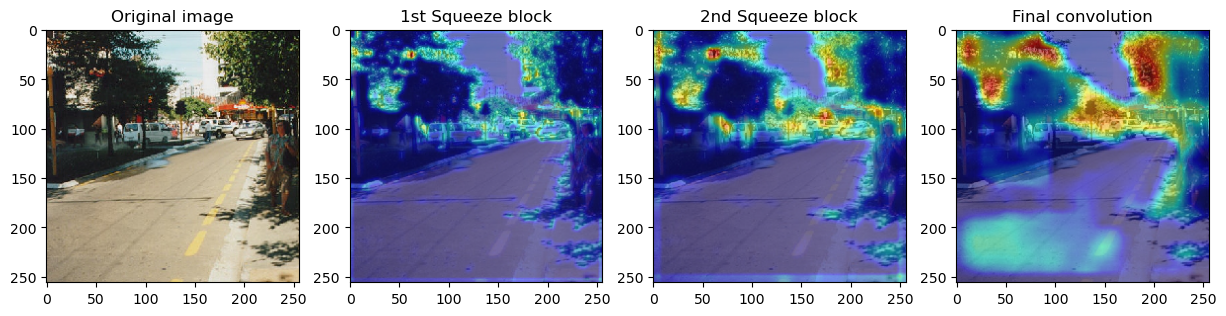

In [7]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
ax[0].imshow(img)
ax[1].imshow(visualizations[0])
ax[2].imshow(visualizations[1])
ax[3].imshow(visualizations[2])

ax[0].set_title("Original image")
ax[1].set_title(f"1st Squeeze block")
ax[2].set_title(f"2nd Squeeze block")
ax[3].set_title(f"Final convolution");

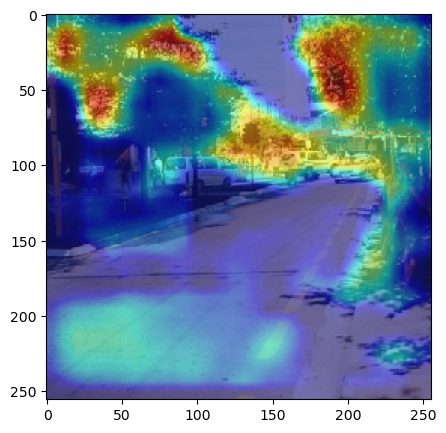

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(visualizations[-1]);